In [1]:
import matplotlib
matplotlib.use('Agg')

%matplotlib inline
from matplotlib import pyplot as plt



In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data


FLAGS = None



In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
FLAGS = None


mnist = input_data.read_data_sets("/tmp/tensorflow/mnist/input_data", one_hot=True)



Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


the following is code for normal GD

In [4]:

class clusterdTrain(object):
	"""docstring for train"""

	def __init__(self, images=None, lables = None):
		super(clusterdTrain, self).__init__()
		if images is None or lables is None:
			final_ind = np.load("final_ind_cluster.npy")
			self.images = np.load("minstImage.npy")[final_ind]
			self.lables = np.load("minstLabels.npy")[final_ind]
		else:
			self.images = images
			self.lables = lables
		self.length = len(self.images)
		self.curPos = 0
		self.epoch = 0
	def next_batch(self, size):
		self.curPos += size
		if self.curPos > self.length:
			self.epoch += 1
			self.curPos = size 
		return [self.images[self.curPos - size:self.curPos], \
				self.lables[self.curPos - size:self.curPos]]




def Grad(Train,R=6000,B=20):
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y = tf.matmul(x, W) + b

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 10])

    # The raw formulation of cross-entropy,
    #
    #   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
    #                                 reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
    # outputs of 'y', and then average across the batch.
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    # Train
    loss= 10
    acc = 0
    ploss = False
    ploss = True
    loss_list_normal=[]
    acc_list = []
    for i in range(R):
        batch_xs, batch_ys = Train.next_batch(B)


        if ploss:
            _, loss, acc = sess.run([train_step,cross_entropy,accuracy], feed_dict={x: batch_xs, y_: batch_ys})
        else:
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        if i % 1 ==0:
    #         print (i, loss)
            loss_list_normal.append(loss)
            acc_list.append(acc)
    # Test trained model

    print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))
    return loss_list_normal,acc_list

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')



def deepGrad(Train,R=6000,B=20):
    x = tf.placeholder(tf.float32, [None, 784])
    W_conv1 = weight_variable([5, 5, 1, 4])
    b_conv1 = bias_variable([4])
    x_image = tf.reshape(x, [-1,28,28,1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    
    W_conv2 = weight_variable([5, 5, 4, 8])
    b_conv2 = bias_variable([8])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight_variable([7 * 7 * 8, 128])
    b_fc1 = bias_variable([128])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*8])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = weight_variable([128, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    
    
    
    
    

#     W = tf.Variable(tf.zeros([784, 10]))
#     b = tf.Variable(tf.zeros([10]))
#     y = tf.matmul(x, W) + b

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 10])
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    
    
    loss = 10 
    acc = 0
    ploss = True
#     ploss = False
    loss_list=[]
    acc_list = []
    for i in range(R):
        batch = Train.next_batch(B)
        if i%1 == 0:
            print (i)
            test_accuracy = accuracy.eval(feed_dict={
                x:mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            train_loss = cross_entropy.eval(feed_dict={x:batch[0],y_:batch[1],keep_prob: 1.0})
            acc_list.append(test_accuracy)
            loss_list.append(train_loss)
            
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print("test accuracy %g"%accuracy.eval(feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))    
    return loss_list,acc_list

In [6]:
images = np.load("minstImage.npy")
lables = np.load("minstLabels.npy")
final_ind = np.load("final_ind_cluster.npy")
final_labels  = lables[final_ind]
final_images = images[final_ind]
clusteredData = clusterdTrain(final_images,final_labels)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

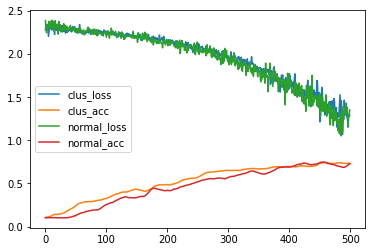

In [9]:
R=500
B=30
loss_list_normal,acc_list_normal = deepGrad(mnist.train,R,B)
loss_list_clus,acc_list_clus = deepGrad(clusteredData,R,B)

np.save("loss_list_normal_R_"+str(R)+"_B_"+str(B),loss_list_normal)

np.save("acc_list_normal_R_"+str(R)+"_B_"+str(B),acc_list_normal)

np.save("loss_list_clus_R_"+str(R)+"_B_"+str(B),loss_list_clus)

np.save("acc_list_clus_R_"+str(R)+"_B_"+str(B),acc_list_clus)


plt.plot(loss_list_clus,label = "clus_loss")
plt.plot(acc_list_clus, label = "clus_acc")
plt.plot(loss_list_normal, label = "normal_loss")
plt.plot(acc_list_normal, label= "normal_acc")
plt.legend()
plt.savefig('deep_cmpGradient_'+str(R)+'_'+str(B)+'.png')

In [12]:
?tf.initialize_all_variables

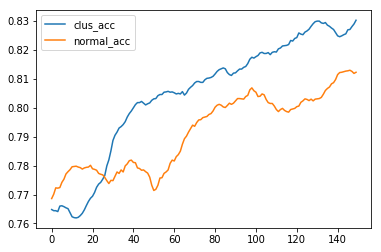

In [129]:
start=350
end  = 500
# plt.plot(loss_list_clus[start:end],label = "clus_loss")
plt.plot(acc_list_clus[start:end], label = "clus_acc")
# plt.plot(loss_list_normal[start:end], label = "normal_loss")
plt.plot(acc_list_normal[start:end], label= "normal_acc")
plt.legend()
plt.savefig('deep_cmpGradient_'+str(R)+'_'+str(B)+'.png')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
test accuracy 0.1422


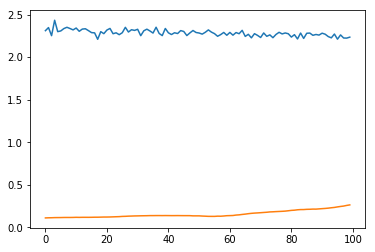

In [8]:
R=40
B=20
loss_list_clus,acc_list_clus = deepGrad(clusteredData,R,B)
plt.plot(loss_list_normal)
plt.plot(acc_list_normal)
plt.savefig('deep_normalGradient_'+str(R)+'_'+str(B)+'.png')

In [91]:
R=200
B=10
loss_list_normal,acc_list_normal = Grad(mnist.train,R,B)
loss_list_clustered,acc_list_clustered = Grad(clusteredData,R,B)



0.7191
0.8469


for batch size 10
........
clustered
min value of loss 0.0534529
var of loss 0.21062
mean of loss 0.713406
........
normal
min value of loss 0.0207945
var of loss 0.619472
mean of loss 0.904697
.................
compare
variance of clustered - variance of normal -0.408852


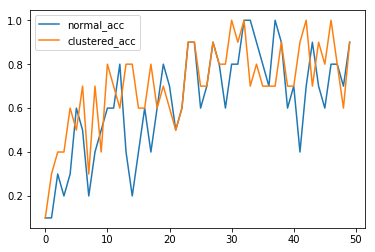

In [93]:

# nplot = plt.plot(loss_list_normal,label = "normal_loss")
# cplot = plt.plot(loss_list_clustered,label = "clustered_loss")
plt.plot(acc_list_normal[:50],label = "normal_acc")
plt.plot(acc_list_clustered[:50], label = "clustered_acc")



plt.legend()
plt.savefig('CompGradient_'+str(R)+'_'+str(B)+'.png')


print ("for batch size",B)
print ("........")
print ("clustered")
print ("min value of loss",np.min(loss_list_clustered))
cluster_var  = np.var(loss_list_clustered)
print ("var of loss",cluster_var)
print ("mean of loss",np.mean(loss_list_clustered))
print ("........")
print ("normal")
print ("min value of loss",np.min(loss_list_normal))
normal_var = np.var(loss_list_normal)
print ("var of loss",normal_var)
print ("mean of loss",np.mean(loss_list_normal))
print (".................")

print ("compare")
print ("variance of clustered - variance of normal",cluster_var - normal_var)

the following is for clustered GD

In [68]:
print ("clustered")
print (np.min(loss_list_clustered))
print (np.var(loss_list_clustered))
print ("normal")
print (np.min(loss_list_normal))
print (np.var(loss_list_normal))

clustered
0.517321
0.167033
normal
0.467159
0.193944


In [162]:
clusteredData.next_batch(10)

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])]

In [ ]:
mnist.train.images

In [4]:
?np.save

In [ ]:
final_ind = range(len(filtered_ind))
for i in range(4987):
    for j in range(10):
        final_ind[i*10+j] = filtered_ind[4987*j+i]

In [6]:
acc_list_clus = np.load("loss_list_normal_R_1500_B_30.npy")
acc_list_normal = np.load("loss_list_normal_R_1500_B_30.npy")

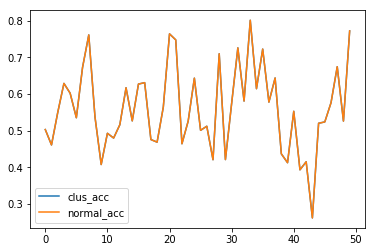

In [11]:
R=1500
B=30

# plt.plot(loss_list_clus,label = "clus_loss")
plt.plot(acc_list_clus[1000:1050], label = "clus_acc")
# plt.plot(loss_list_normal, label = "normal_loss")
plt.plot(acc_list_normal[1000:1050], label= "normal_acc")
plt.legend()
plt.savefig('deep_cmpGradient_'+str(R)+'_'+str(B)+'.png')